In [1]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns

from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, make_scorer, precision_score
from hyperopt import space_eval
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

import statsmodels.api as sm
from scipy.stats import t



##### Data clean up

In [48]:
df = pd.read_csv('Radiators.csv')

In [49]:
df.head()

,Type,Manufacturer,Range,Panel Radiator Type,Column Style,Material,Height,Width,Sections / Elements,Cols,Manu. Part Number,Heat Output Watts (dT50),Heat Output Btu/hr (1),n coefficient Strategy,n coefficient
0,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,500,15.00,NaN,143650,255,870,Default,1.30
1,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,1000,30.00,NaN,143651,509,1737,Default,1.30
2,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,1500,45.00,NaN,143652,764,2608,Default,1.30
3,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,2000,60.00,NaN,143653,1018,3474,Default,1.30
4,Panel,Stelrad,Stelrad Compact,11.00,NaN,Steel,300,2500,75.00,NaN,143654,1273,4345,Default,1.30


In [50]:
df_new = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      6172 non-null   object 
 1   Manufacturer              6172 non-null   object 
 2   Range                     6172 non-null   object 
 3   Panel Radiator Type       1404 non-null   float64
 4   Column Style              4675 non-null   object 
 5   Material                  6172 non-null   object 
 6   Height                    6172 non-null   int64  
 7   Width                     6172 non-null   int64  
 8   Sections / Elements       5014 non-null   float64
 9   Cols                      4675 non-null   float64
 10  Manu. Part Number         5980 non-null   object 
 11  Heat Output Watts (dT50)  6172 non-null   int64  
 12  Heat Output Btu/hr (1)    1849 non-null   object 
 13  n coefficient Strategy    1157 non-null   object 
 14  n coeffi

In [51]:
df = df.drop(['Manufacturer','Range','Column Style', 'Material','Cols','Manu. Part Number','Heat Output Btu/hr (1)','n coefficient Strategy', 'n coefficient'], axis = 1)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      6172 non-null   object 
 1   Panel Radiator Type       1404 non-null   float64
 2   Height                    6172 non-null   int64  
 3   Width                     6172 non-null   int64  
 4   Sections / Elements       5014 non-null   float64
 5   Heat Output Watts (dT50)  6172 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 289.4+ KB


In [53]:
df = df.loc[df.Type == 'Panel']

In [54]:
df = df.drop('Type', axis =1)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1404 entries, 0 to 5788
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Panel Radiator Type       1404 non-null   float64
 1   Height                    1404 non-null   int64  
 2   Width                     1404 non-null   int64  
 3   Sections / Elements       477 non-null    float64
 4   Heat Output Watts (dT50)  1404 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 65.8 KB


Above, we can see that 'Sections / Elements' contains many nan values. As Width is a good indicator anyway, will drop 'Sections / Elements' feature.

In [56]:
df = df.drop('Sections / Elements', axis =1)

In [57]:
df = df.rename(columns = {'Heat Output Watts (dT50)' : 'Heat', 'Panel Radiator Type' : 'panel_radiator_type' })

In [58]:
df

,panel_radiator_type,Height,Width,Heat
0,11.00,300,500,255
1,11.00,300,1000,509
2,11.00,300,1500,764
3,11.00,300,2000,1018
4,11.00,300,2500,1273
...,...,...,...,...
5784,22.00,2000,700,2772
5785,22.00,2200,400,1692
5786,22.00,2200,500,2115
5787,22.00,2200,600,2538


Before performing the EDA, we will remove all data points which are not relevant for Warmur (massive rads).

In [59]:
df = df.loc[df.Height <= 750]
df = df.loc[df.Height >= 300]
df = df.loc[df.Width <= 1600]
df = df.loc[df.Width >= 400]


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 915 entries, 0 to 5769
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   panel_radiator_type  915 non-null    float64
 1   Height               915 non-null    int64  
 2   Width                915 non-null    int64  
 3   Heat                 915 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 35.7 KB


We should also convert 'panel_radiator_type' to string as it will be easier to work with.

In [61]:
df['panel_radiator_type'] = df['panel_radiator_type'].astype(int)


##### Feature Engineering

We will quickly feature engineer panel_radiator_type, and replace it with number of panels and fins. 

In [62]:
df['panels'] = df['panel_radiator_type'] // 10
df['fins'] = df['panel_radiator_type'] % 10


In [63]:
df = df.drop('panel_radiator_type', axis = 1)

##### EDA

In [18]:
import random
seed = random.randint(1000,9999)
print(seed)

4542


In [20]:
seed = 4542

In [64]:
df.describe()

,Height,Width,Heat,panels,fins
count,915.00,915.00,915.00,915.00,915.00
mean,545.03,961.86,1358.77,1.88,1.61
std,136.74,368.18,789.76,0.68,0.80
min,300.00,400.00,190.00,1.00,0.00
25%,450.00,600.00,766.50,1.00,1.00
50%,600.00,1000.00,1199.00,2.00,1.00
75%,700.00,1200.00,1760.00,2.00,2.00
max,750.00,1600.00,4774.00,3.00,3.00


##### Comments

- std of many of our features and target variable are significant


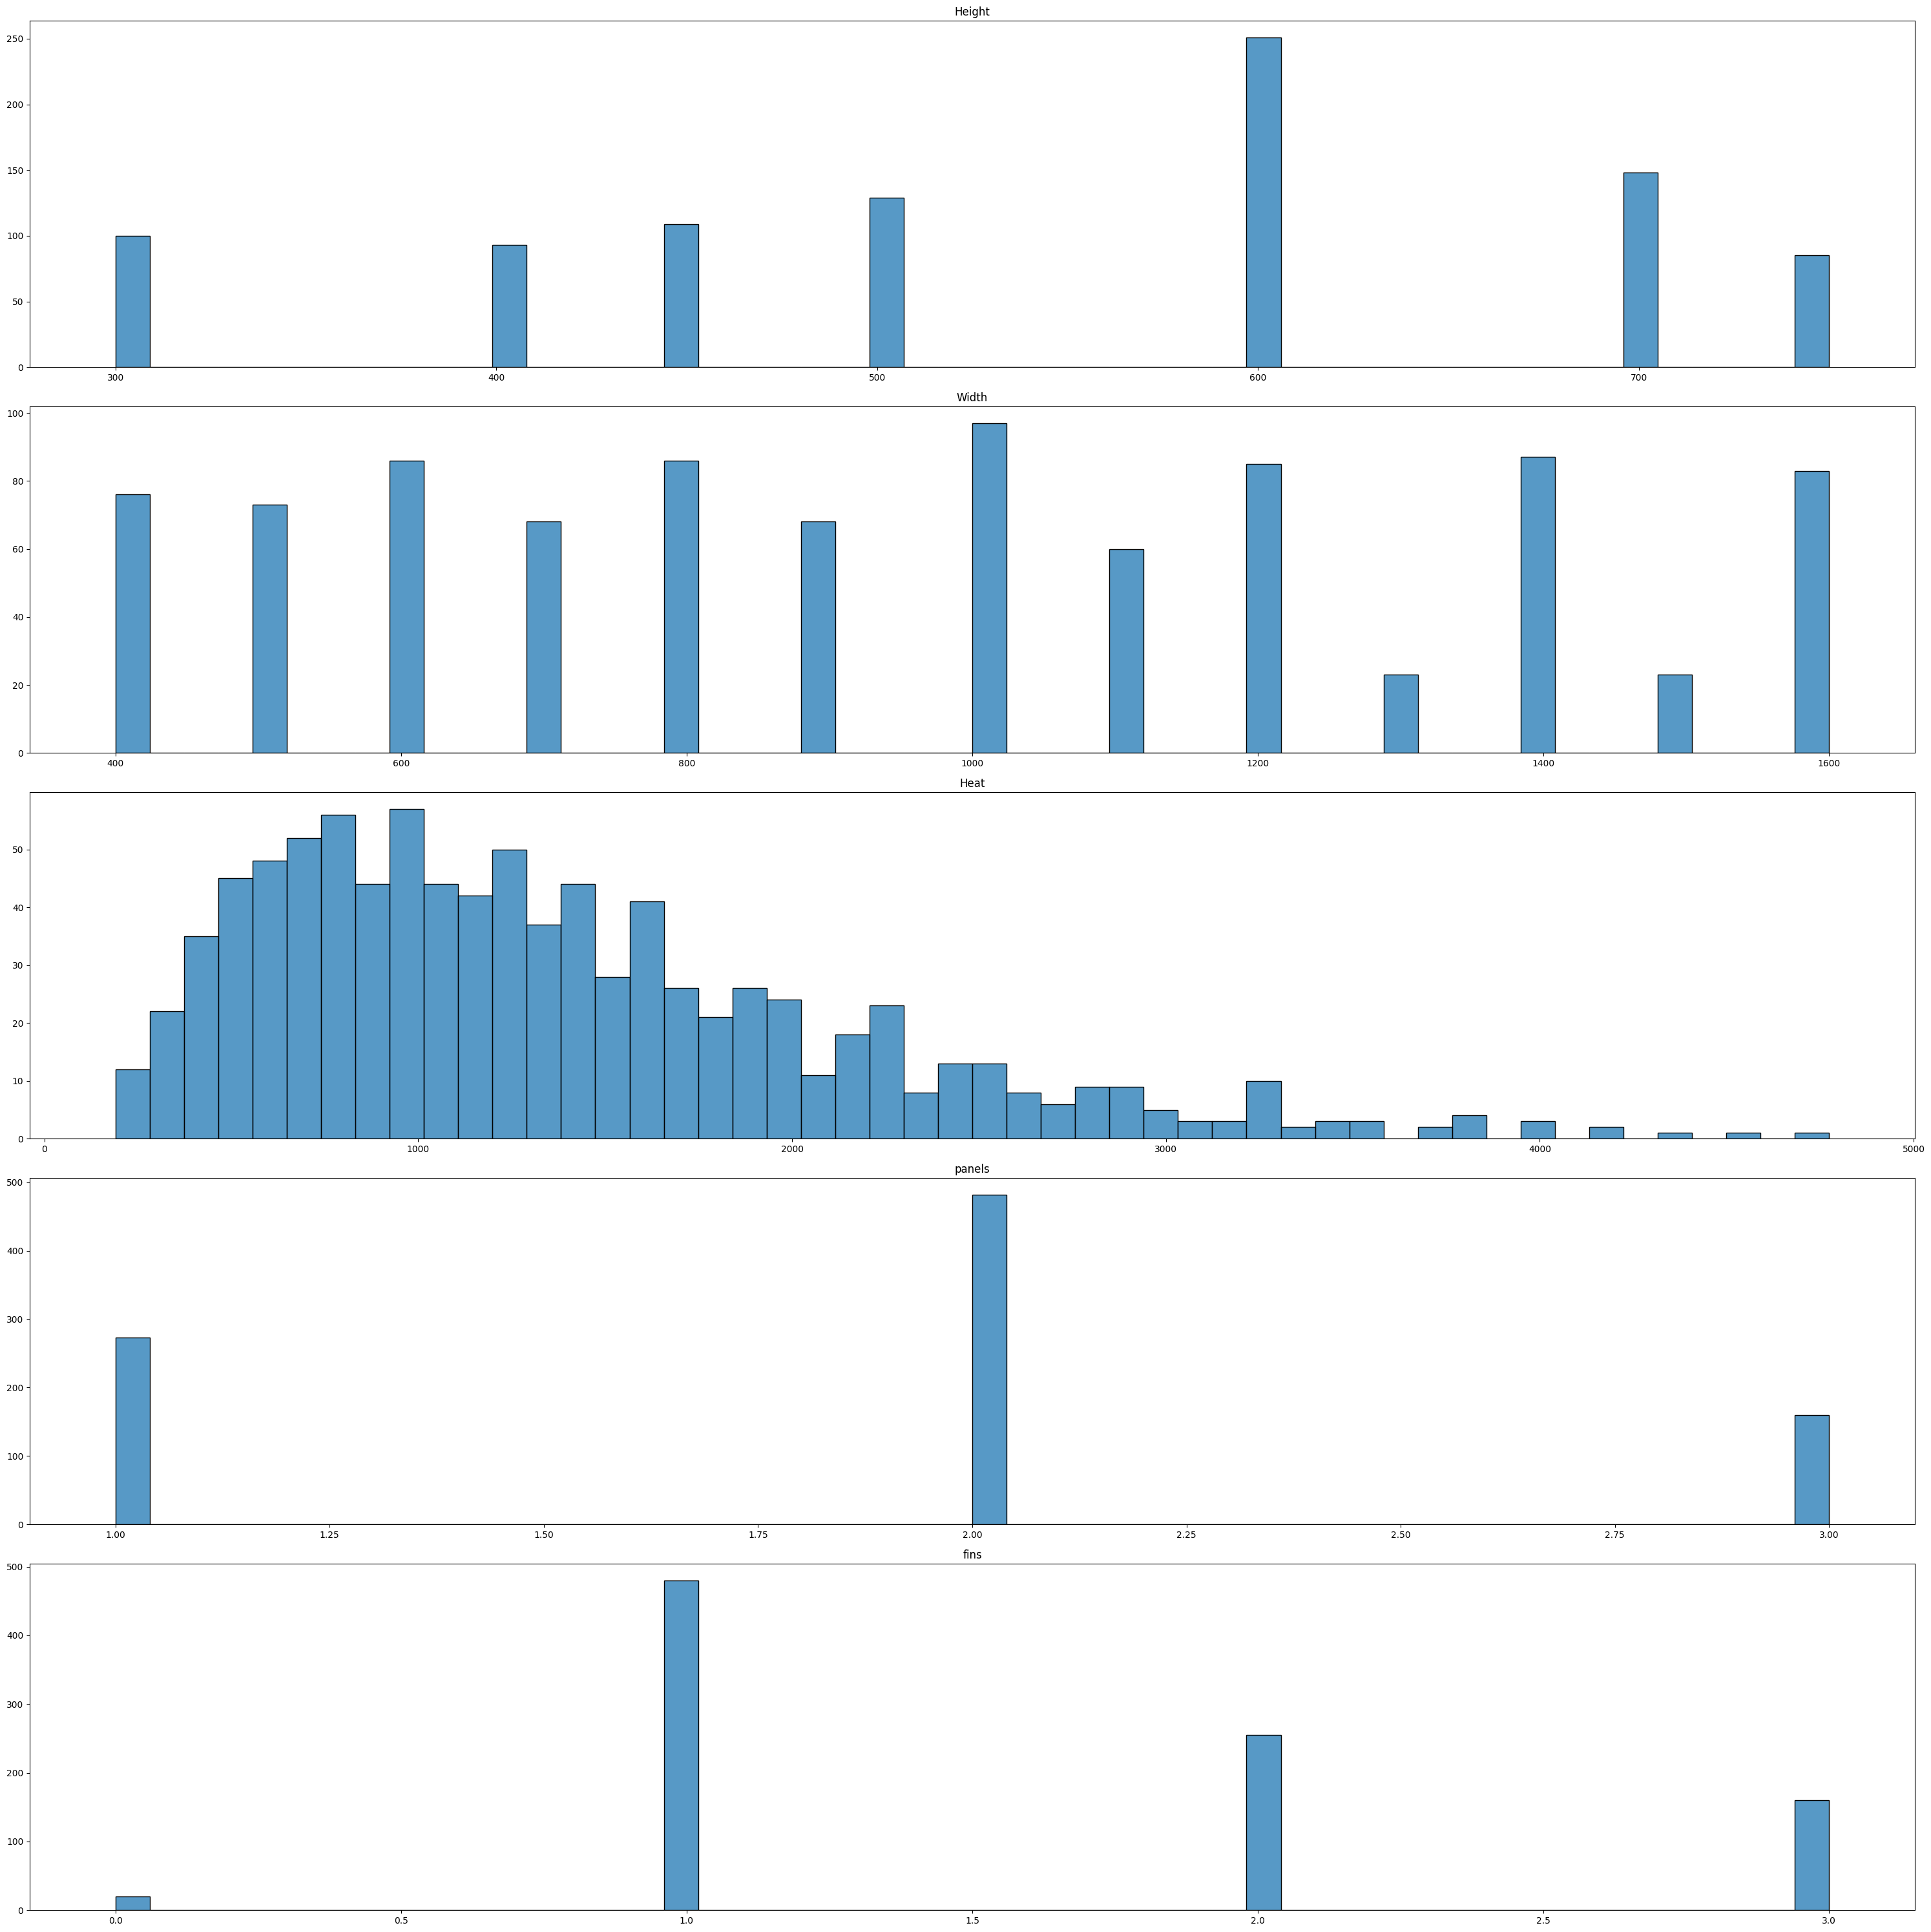

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(30,30), ncols=1, nrows=5)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

##### Comments

- Heat strongly skewed to the left. Might have to consider applying transform here (like box cox)
- Height, Width quite evenly distributed.
- Few instances of 0 fins.

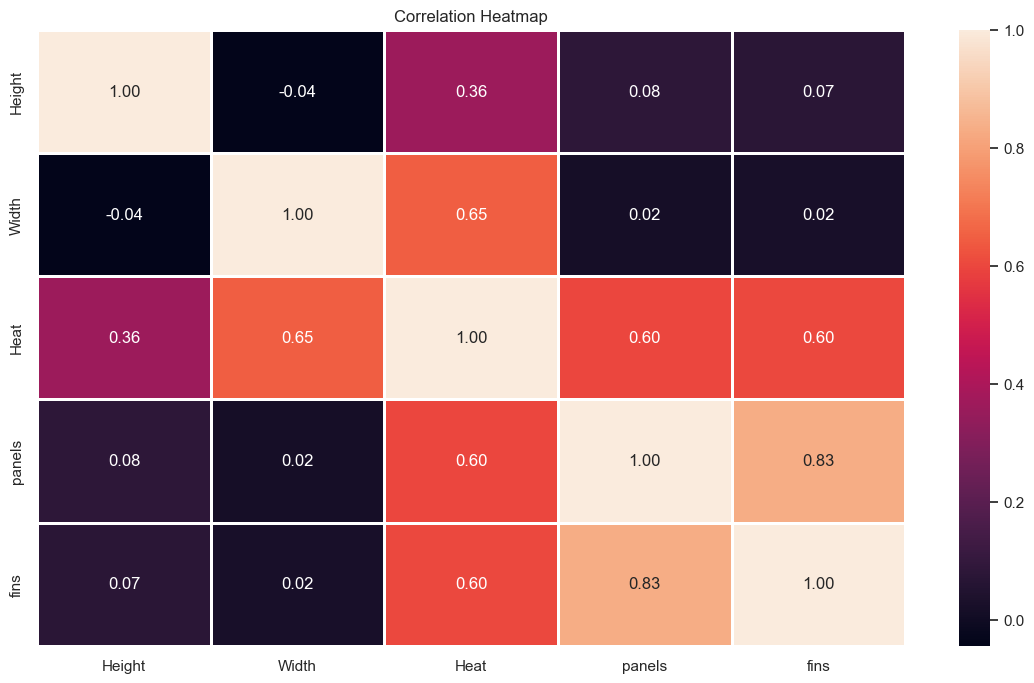

In [23]:
# Or without droping the output directly, easy to see all pairs
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

#### Comments
- Some correlation between fins and panels, which makes sense. No strong correlations between target variable and any feature variable.

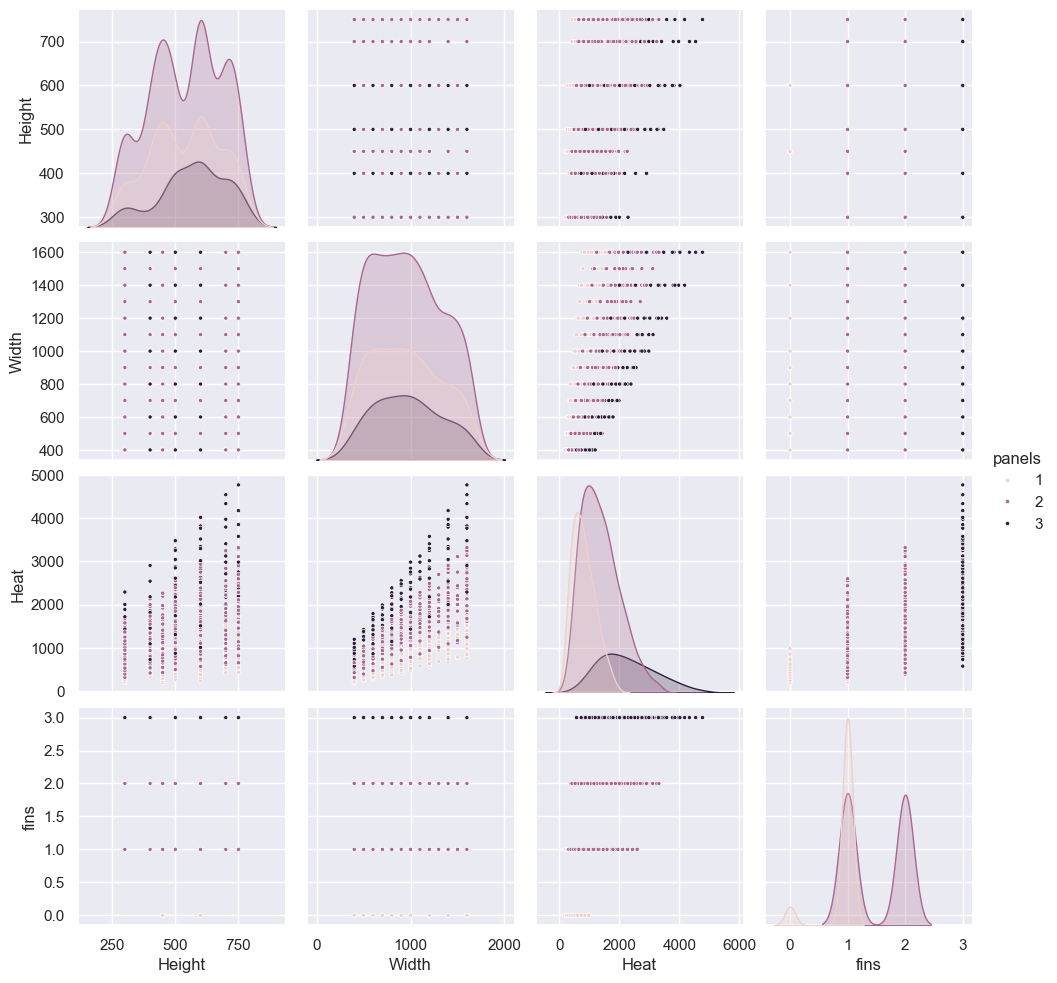

In [68]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue = 'panels', markers=".")
plt.show()

Above, we can see that panel_radiator type functions in similar way as 'cols' in column_rad data, which is to be expected.

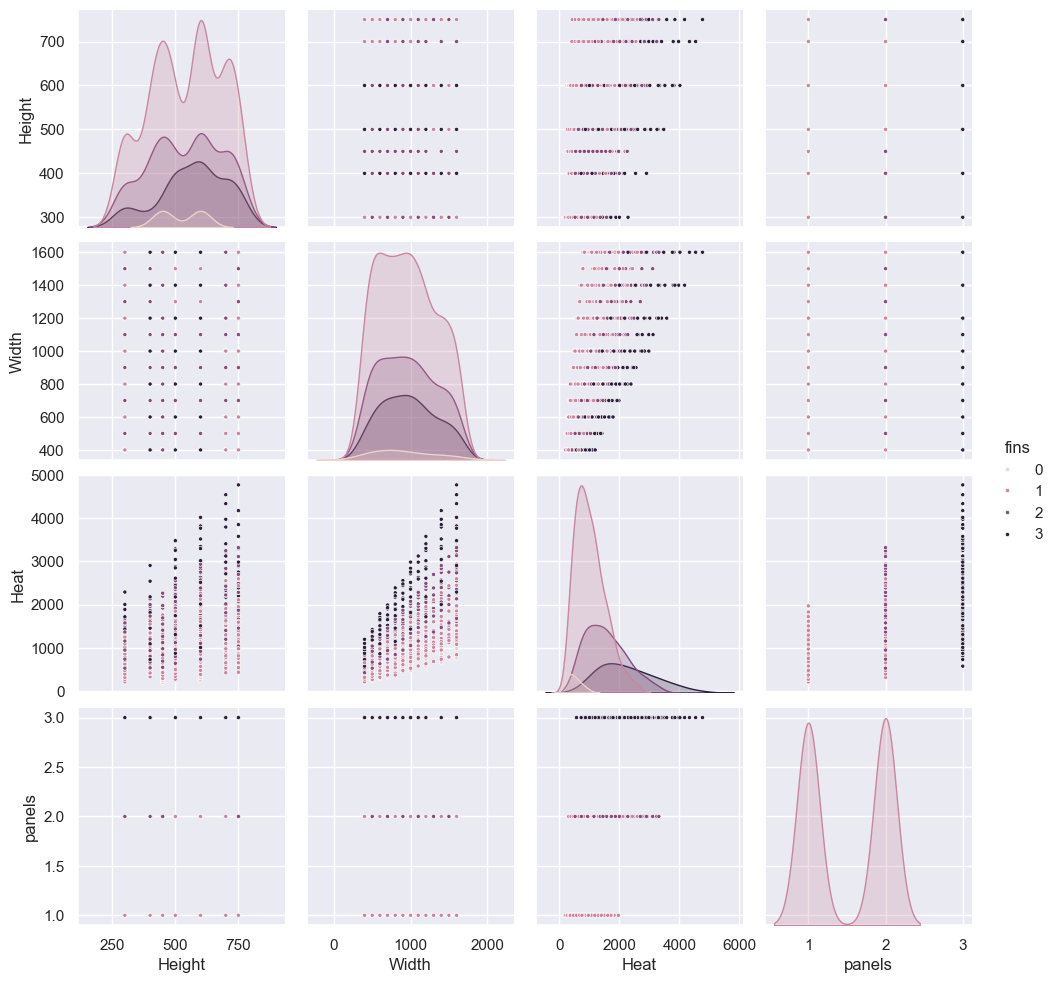

In [69]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue='fins', markers=".")
plt.show()

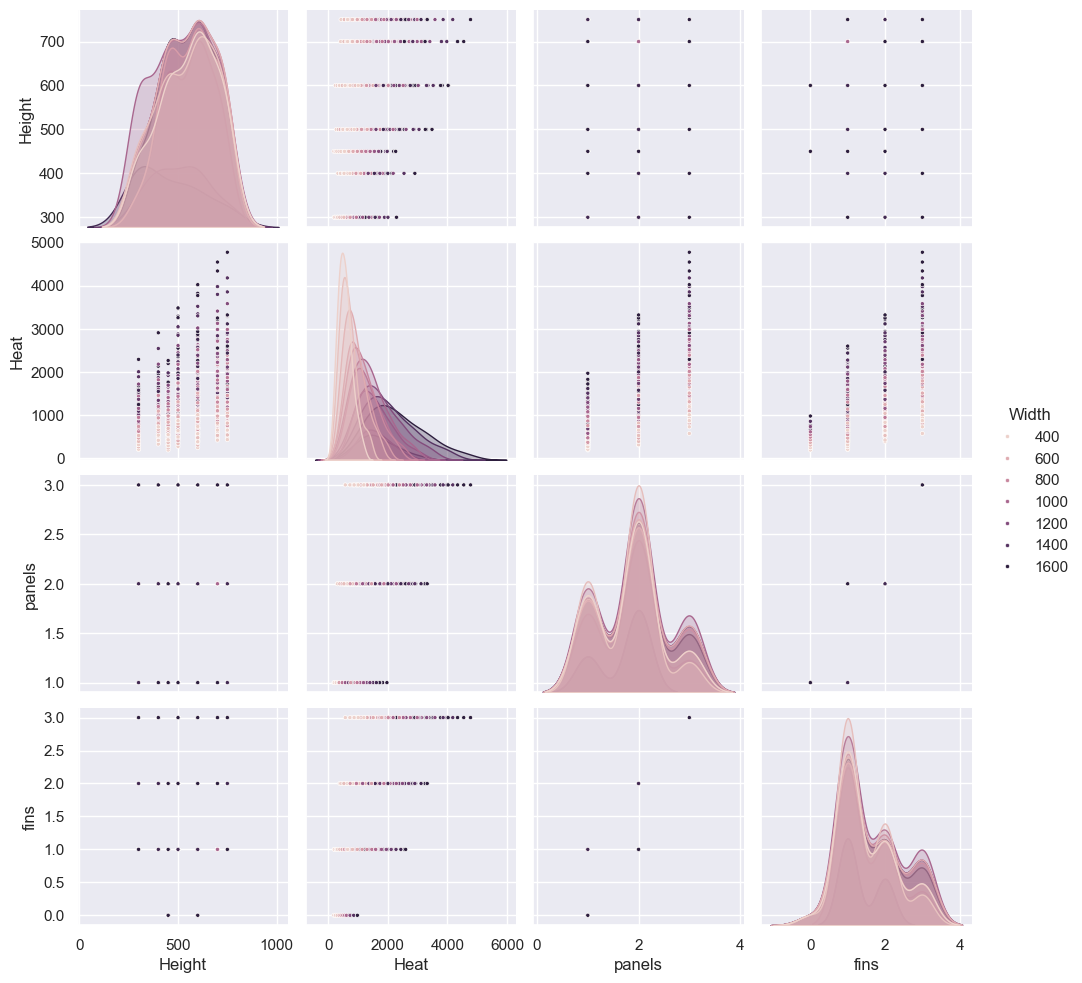

In [70]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.pairplot(df, hue='Width', markers=".")
plt.show()

##### Comments

- Interesting 'linear' relationships between width and heat, and height and heat, as seen in column_rad data.


In [26]:
X = df.drop(['Heat'], axis = 1)
features = list(X.columns)
X = X.values
y = df['Heat'].copy()
y = y.values

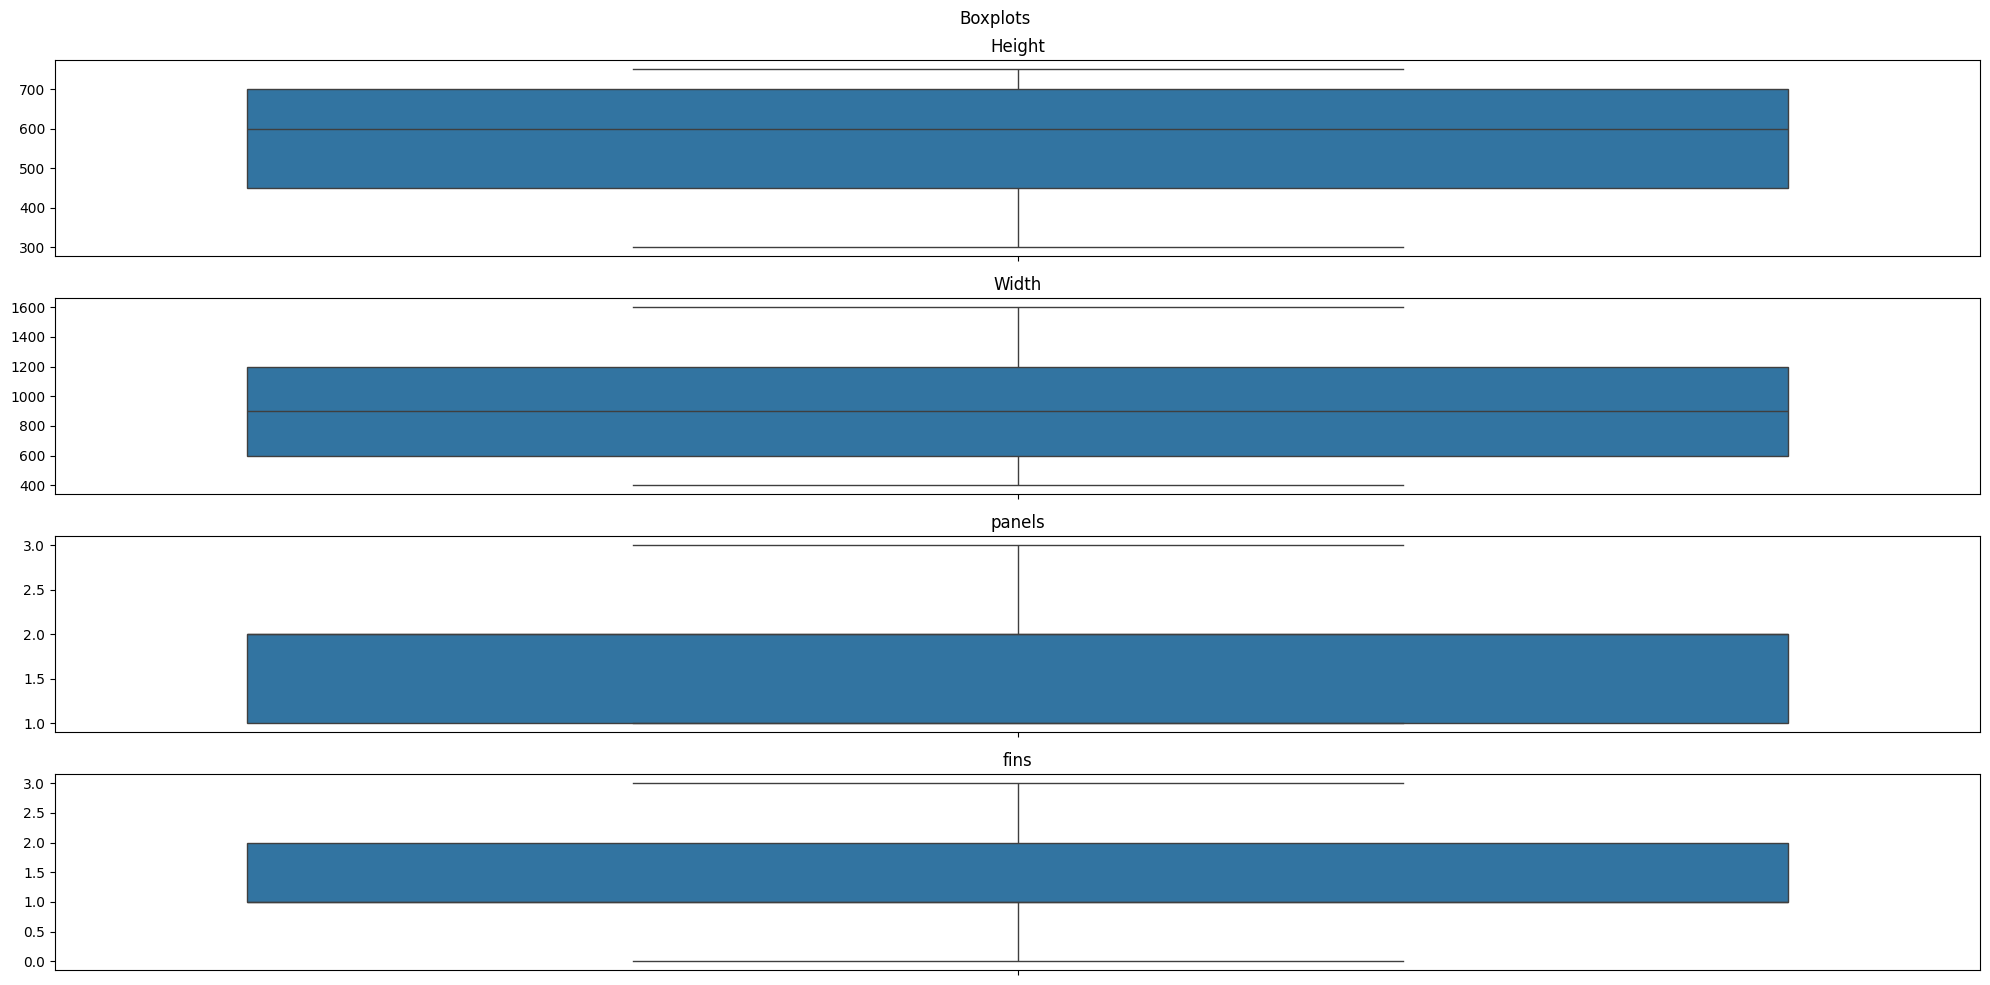

In [22]:
fig, axes = plt.subplots(figsize = (20,10), ncols = 1, nrows = 4, sharex = True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.boxplot(y = X[:,i], ax = ax) 
    ax.set_title(features[i])
    ax.set_ylabel("")
    
plt.suptitle("Boxplots")
plt.tight_layout()
plt.show()

##### Comments

- No clear outliers in data

#### Training test data splits

In [ ]:
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)


'''



In [28]:

'''
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)






### Linear Regression Model

In [29]:
def print_evaluation(y_train, y_fit, y_test, y_pred):
    '''Prints the model evaluation.
    '''
    # The mean squared error of the training set 
    print("Training Mean squared error: %.3f" % mean_squared_error(y_train, y_fit))
    # The root mean squared error of the training set 
    print("Training Root-Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_train, y_fit)))
    # The coefficient of determination of the training set 
    print("Training R squared: %.3f" % r2_score(y_train, y_fit))
    
    # The mean squared error of the test set 
    print("Test Mean squared error: %.3f" % mean_squared_error(y_test, y_pred))
    # The root mean squared error of the test set 
    print("Test Root-Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    # The coefficient of determination of the test set 
    print("Test R squared: %.3f" % r2_score(y_test, y_pred))

In [30]:
def get_coefs(m):
    '''Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    '''
    # If pipeline, use the last step as the model
    if (isinstance(m, Pipeline)):
        m = m.steps[-1][1]
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [31]:
def plot_fit(y, y_hat):
    '''Plotting an overview of the model fit including ture vs predicted scores, 
    residuals and a QQ plot
    '''
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'residual': y - y_hat}
    )
    
    plt.figure(figsize=(12, 3))
    
    plt.subplot(131)
    sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={
        'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
    sns.scatterplot(x='y', y='y_hat', data=res).set_title("True vs Predicted ")
    
    plt.subplot(132)
    sns.scatterplot(x='y_hat', y='residual', data=res).set_title("Residuals")
    plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
    
    plt.subplot(133)
    stats.probplot(res['residual'], dist="norm",plot=plt)
    plt.title('Probability Plot of Residuals')
    
    plt.tight_layout()

In [32]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([
        ("count_pre", MinMaxScaler()), # Applied to the count variables
        ('model', LinearRegression(fit_intercept=True))
])


y_train = y_train.reshape(-1,1)
target_scaler  = MinMaxScaler()

y_train_scaled = target_scaler.fit_transform(y_train)



In [33]:

linreg_fit = lin_reg.fit(X_train, y_train_scaled.ravel())

y_pred_scaled = linreg_fit.predict(X_test)
y_fit_scaled = linreg_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [34]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 56093.259
Training Root-Mean squared error: 236.840
Training R squared: 0.908
Test Mean squared error: 52530.239
Test Root-Mean squared error: 229.195
Test R squared: 0.922


In [35]:
print(linreg_fit['model'].coef_)
print(linreg_fit['model'].intercept_)

[0.19308901 0.36319077 0.14790576 0.19689861]
-0.19143161883877963


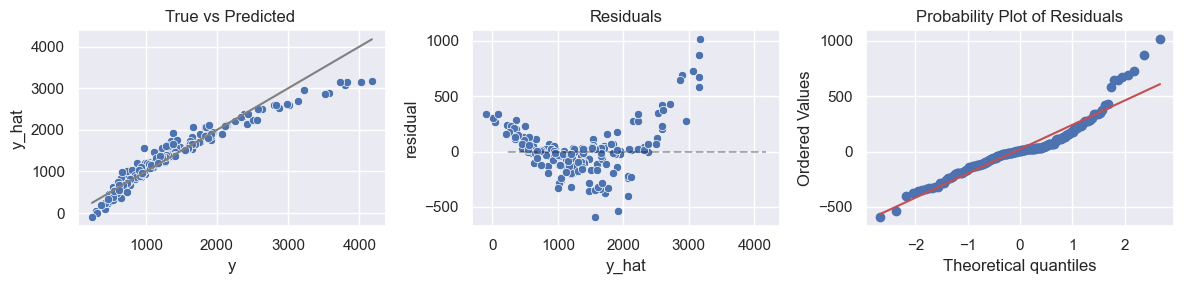

In [36]:
plot_fit(y_test, y_pred)


#### Comments

- It appears that linear model is overpredicting for low values of heat output, and underpredicting for high values of heat output.

### Polynomial Regression Model

From EDA, I've gotten hunch that including interaction term in polynomial expansion between features may suffice for this problem.

In [39]:
pf_interact = PolynomialFeatures(interaction_only=True,include_bias=False)

# Overall ML pipeline



poly_interact_pipe = Pipeline([
        ("count_pre", MinMaxScaler()), # Applied to the count variables
        ('poly_interact', pf_interact),
        ('model', LinearRegression(fit_intercept=True))
])

poly_interact_fit = poly_interact_pipe.fit(X_train, y_train_scaled.ravel())


y_pred_scaled = poly_interact_fit.predict(X_test)
y_fit_scaled = poly_interact_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [40]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 4034.517
Training Root-Mean squared error: 63.518
Training R squared: 0.994
Test Mean squared error: 4998.522
Test Root-Mean squared error: 70.700
Test R squared: 0.990


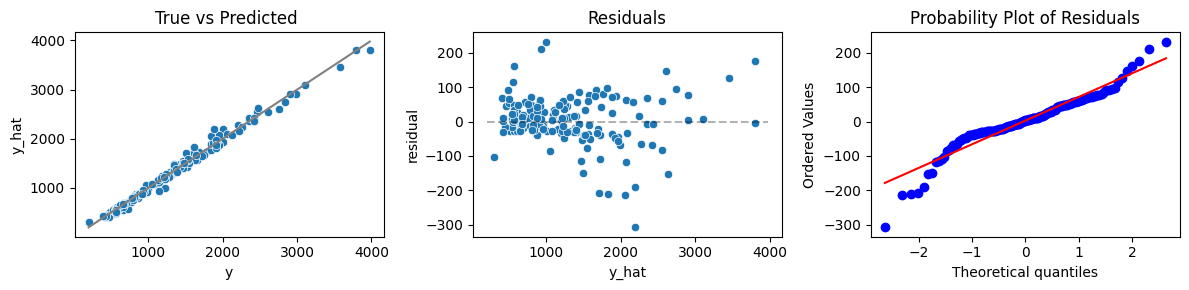

In [41]:
plot_fit(y_test, y_pred)


Much improved, but rmse still significant. R squared looking good. This means that the model captures most of the variability of 'Heat'. However, rmse still significant. Also, loooking at residual plot, we can see that model is far from perfect. It appears to overpredict for low heat values.

#### Polynomial expansion with interaction

In [37]:

pf = PolynomialFeatures()

# Overall ML pipeline

poly_interact_pipe = Pipeline([
        ("count_pre", MinMaxScaler()), # Applied to the count variables
        ('poly', pf),
        ('model', LinearRegression(fit_intercept=True))
])



parameters = {
    'poly__degree': np.arange(1,20,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid_search = GridSearchCV(poly_interact_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

In [38]:
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)
print("coefficents", grid_search.best_estimator_['model'].coef_)

best param:  {'poly__degree': np.int64(3)}
best score:  -3725.264070460489
coefficents [[-9.93149738e-11  1.74511590e+02  4.30674754e+02  1.88767124e+02
   2.04345177e+02 -3.88170534e+01  6.75854903e+02  3.58764372e+02
   2.97698244e+02 -1.16852083e+02  6.49453550e+02  7.56445959e+02
   3.44762444e+01  4.49174465e+01  7.07339627e+01  9.03608476e-01
  -1.24306424e+02 -1.38074101e+02  6.01405648e+01 -3.34723604e+01
   5.95916675e+02  6.41736728e+02 -3.67287787e+01 -6.12417412e+01
  -4.58244212e+01  5.83062305e+01  1.25606352e+02  3.13558495e+00
  -2.69783259e+02 -6.62844513e+01  1.39350044e+02 -4.26691954e+01
  -3.74485943e+01 -2.36562777e+01 -1.30155115e+00]]


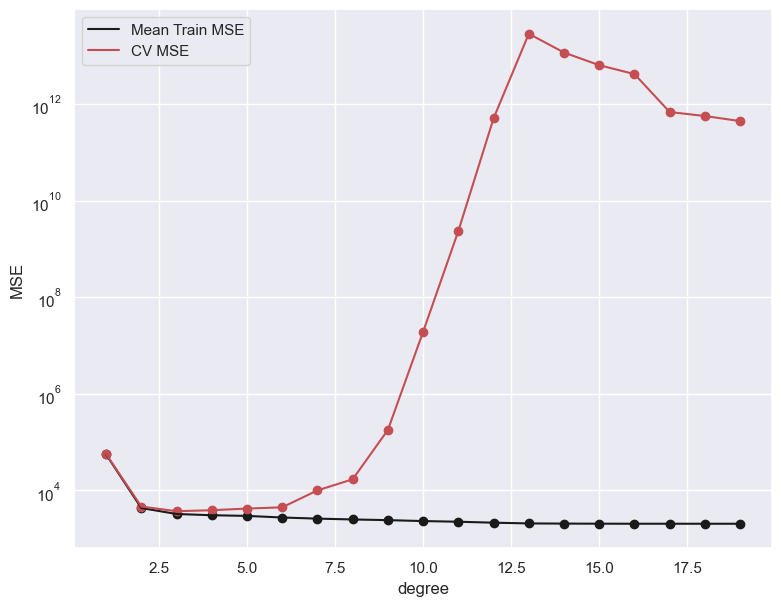

In [39]:
degree = np.arange(1,20,1)
fig, ax = plt.subplots(figsize=(9,7), ncols=1, nrows=1)
plt.scatter(degree,-grid_search.cv_results_['mean_train_score'], color='k')
plt.plot(degree,-grid_search.cv_results_['mean_train_score'], color='k', label='Mean Train MSE')
plt.scatter(degree,-grid_search.cv_results_['mean_test_score'], color='r')
plt.plot(degree,-grid_search.cv_results_['mean_test_score'], color='r', label='CV MSE')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('degree')
ax.set_ylabel('MSE')
plt.show()

In [40]:
pf = PolynomialFeatures(degree= 3)




poly_interact_pipe_final = Pipeline([
        ("count_pre", MinMaxScaler()), # Applied to the count variables
        ('poly', pf),
        ('model', LinearRegression(fit_intercept=True))
])

poly_interact_fit = poly_interact_pipe_final.fit(X_train, y_train_scaled.ravel())


y_pred_scaled = poly_interact_fit.predict(X_test)
y_fit_scaled = poly_interact_fit.predict(X_train)

y_fit = target_scaler.inverse_transform(y_fit_scaled.reshape(-1, 1))
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_fit = y_fit.ravel()
y_pred = y_pred.ravel()

In [41]:
print_evaluation(y_train, y_fit, y_test, y_pred)


Training Mean squared error: 3305.924
Training Root-Mean squared error: 57.497
Training R squared: 0.995
Test Mean squared error: 3731.462
Test Root-Mean squared error: 61.086
Test R squared: 0.994


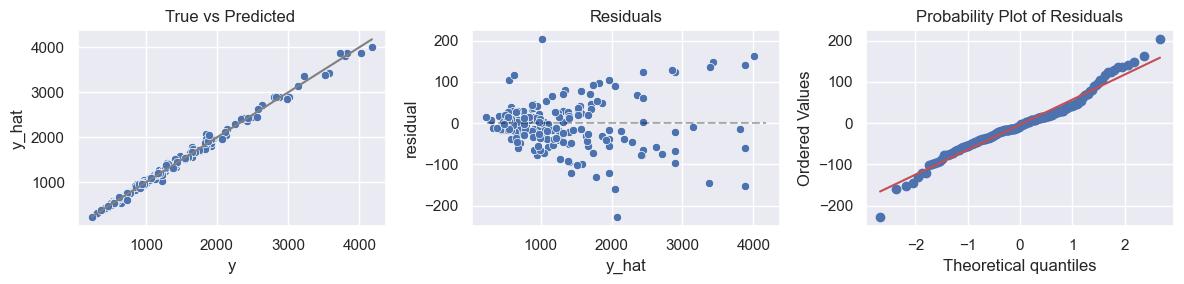

In [42]:
plot_fit(y_test, y_pred)


Summary Table:
       range  Mean_Percentage_Error
0      0-500                   3.02
1   500-1000                   3.64
2  1000-1500                   3.55
3  1500-2000                   3.43
4  2000-4000                   2.81


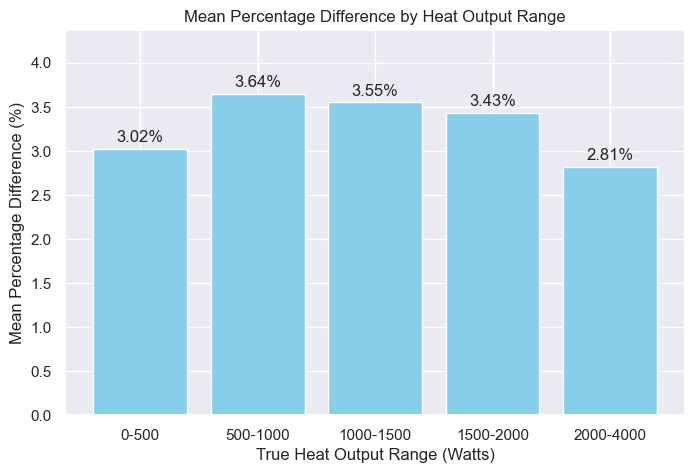

In [47]:
pct_diff = np.abs(y_test - y_pred) / y_test * 100

df_error = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'pct_diff': pct_diff
})

# Define bins and labels for y_test.
# Adjust bins if your intended ranges differ.
bins = [0, 500, 1000, 1500, 2000, 4000]
labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000-4000']

# Bin the y_test values into ranges (using right=False means the bin includes the left edge but excludes the right)
df_error['range'] = pd.cut(df_error['y_test'], bins=bins, right=False, labels=labels)

# Create a summary table: here we compute the mean percentage difference per range.
summary = df_error.groupby('range')['pct_diff'].mean().reset_index()
summary.rename(columns={'pct_diff': 'Mean_Percentage_Error'}, inplace=True)
print("Summary Table:")
print(summary)

# Plotting a bar plot of the mean percentage differences
plt.figure(figsize=(8, 5))
bars = plt.bar(summary['range'], summary['Mean_Percentage_Error'], color='skyblue')
plt.xlabel('True Heat Output Range (Watts)')
plt.ylabel('Mean Percentage Difference (%)')
plt.title('Mean Percentage Difference by Heat Output Range')
plt.ylim(0, summary['Mean_Percentage_Error'].max() * 1.2)  # add a little headroom on the y-axis



# Annotate each bar with the mean percentage error values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',  # Format value to 2 decimal places followed by a percent sign
                 xy=(bar.get_x() + bar.get_width() / 2, height),  # Position at the center top of the bar
                 xytext=(0, 3),  # Offset text by 3 points above the bar
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()

Experiment

In [46]:

pf = PolynomialFeatures()
pf_interact = PolynomialFeatures(interaction_only=True)


# Overall ML pipeline
poly_interact_pipe = Pipeline([("min_max", MinMaxScaler()), 
                               ('p_interact', pf_interact),
                               ('p_degrees', ColumnTransformer([
                                   ('poly_1', pf, [0]),
                                   ('poly_2', pf, [1]),
                                   ('poly_3', pf, [2]),
                                   ('poly_4', pf, [3])])),
                               ('model', LinearRegression())])




parameters = {
    'p_degrees__poly_1__degree': np.arange(1,15,1),
    'p_degrees__poly_2__degree': np.arange(1,15,1),
    'p_degrees__poly_3__degree': np.arange(1,15,1),
    'p_degrees__poly_4__degree': np.arange(1,15,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=seed)

grid_search = GridSearchCV(poly_interact_pipe, parameters, cv = kf, scoring = 'neg_mean_squared_error', return_train_score=True).fit(X_train, y_train)

KeyboardInterrupt: 

In [131]:
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)


best param:  {'p_degrees__poly_1__degree': np.int64(6), 'p_degrees__poly_2__degree': np.int64(1), 'p_degrees__poly_3__degree': np.int64(9), 'p_degrees__poly_4__degree': np.int64(6)}
best score:  -405601.6266983473


#### Tests with Standard Error

In [44]:
def error_using_se(pipeline,X_train,y_train_scaled,X_new, target_scaler,alpha = 0.05):
    percentile = (1 - alpha)*100

    X_train_trans = pipeline[:-1].transform(X_train)


    # Add a constant to the design matrix
    X_train_trans = sm.add_constant(X_train_trans)

    # Fit the OLS model using statsmodels.
    ols_model = sm.OLS(y_train_scaled.ravel(), X_train_trans)
    results = ols_model.fit()

    cov_beta = results.cov_params()       # Covariance matrix of the coefficients
    sigma2 = results.mse_resid            # Residual variance

    # transform X_new
    X_new_trans = pipeline[:-1].transform(X_new)


    # For each new observation, compute the variance of prediction.
    # We'll store the standard errors in a list:
    var_pred = np.dot(X_new_trans, np.dot(cov_beta, X_new_trans.T)) + sigma2
    se_pred = np.sqrt(var_pred)

    # Degrees of freedom: n - p, where n is the number of training samples
    deg_freedom = results.df_resid  
    t_val = t.ppf(1-(alpha/2), deg_freedom)  # two-tailed 95% confidence

    # Suppose you also compute the point predictions for X_new:
    y_new_pred_scaled = results.predict(X_new_trans)

    lower_bounds_scaled = y_new_pred_scaled - t_val * se_pred
    upper_bounds_scaled = y_new_pred_scaled + t_val * se_pred

    y_new_pred = target_scaler.inverse_transform(y_new_pred_scaled.reshape(-1, 1))
    lower_bounds = target_scaler.inverse_transform(lower_bounds_scaled.reshape(-1, 1))
    upper_bounds = target_scaler.inverse_transform(upper_bounds_scaled.reshape(-1, 1))
    print(f"Output = {y_new_pred}")
    print(f"Lower {percentile} percentile = {lower_bounds}")
    print(f"Upper {percentile} percentile = {upper_bounds}")

    
    return y_new_pred, lower_bounds, upper_bounds


##### Low heat output 

In [65]:
df

,Height,Width,Heat,panels,fins
0,300,500,255,1,1
1,300,1000,509,1,1
2,300,1500,764,1,1
6,450,400,302,1,1
7,450,500,378,1,1
...,...,...,...,...,...
5765,700,1000,2637,3,3
5766,700,1100,2901,3,3
5767,700,1200,3164,3,3
5768,700,1400,3692,3,3


In [66]:
d_low = df.loc[df.Height == 500]
d_low = d_low.loc[d_low.panels == 3]
d_low = d_low.loc[d_low.Width == 1000]
d_low

,Height,Width,Heat,panels,fins
204,500,1000,2056,3,3
465,500,1000,2169,3,3
789,500,1000,2035,3,3
5362,500,1000,2176,3,3
5738,500,1000,2017,3,3


In [67]:
X_low = np.array([[500.,1000.,3.,3.]])

y_new_pred, lower_bounds, upper_bounds = error_using_se(poly_interact_pipe_final,X_train,y_train_scaled,X_low, target_scaler)

Output = [[2089.0461585]]
Lower 95.0 percentile = [[1972.86025919]]
Upper 95.0 percentile = [[2205.23205781]]


##### Bootstrap

In [96]:

def bootstrap_results(pipeline, X, y, X_new, n_bootstraps, percentile, seed):
    """
    Estimate prediction intervals for X_new by bootstrapping the training data.
    
    Parameters:
    - pipeline: the scikit-learn pipeline (already defined)
    - X, y: datasets used for bootstrapping
    - X_new: new data for which to estimate prediction intervals
    - n_bootstraps: number of bootstrap samples
    - percentile: confidence level (e.g., 95 for a 95% interval)
    
    Returns:
    - lower: lower bound for each prediction
    - upper: upper bound for each prediction
    """
    all_predictions = np.zeros(n_bootstraps)
    
    for _ in range(n_bootstraps):
        # Sample indices with replacement
        X_train_boot, X_test_boot, y_train_boot, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # Clone the pipeline so that each bootstrap fit is independent
        pipeline_clone = clone(pipeline)
        pipeline_clone.fit(X_train_boot, y_train_boot)
        
        # Record predictions for X_new (in the scaled space if needed)
        preds = pipeline_clone.predict(X_new)
        all_predictions[_] = preds
    
    # Convert list to array: shape (n_bootstraps, n_new_samples)
    mean = np.mean(all_predictions)
    std = np.std(all_predictions)

    # Compute lower and upper percentiles for each new sample
    lower_percentile = (100 - percentile) / 2
    upper_percentile = 100 - lower_percentile
    
    lower = np.percentile(all_predictions, lower_percentile, axis=0)
    upper = np.percentile(all_predictions, upper_percentile, axis=0)

    fig, axes = plt.subplots(1, 1, figsize=(18, 5))
    sns.histplot(all_predictions, color="royalblue", kde=True)

    print(f"Lower {percentile} percentile = {lower}")
    print(f"Upper {percentile} percentile = {upper}")
    print(f"Mean Heat Output = {mean}")
    print(f"Standard Deviation Heat Output = {std}")
    
    return all_predictions


Lower 95 percentile = 4824.576266620107
Upper 95 percentile = 4824.576266620107
Mean Heat Output = 4824.576266620107
Standard Deviation Heat Output = 0.0


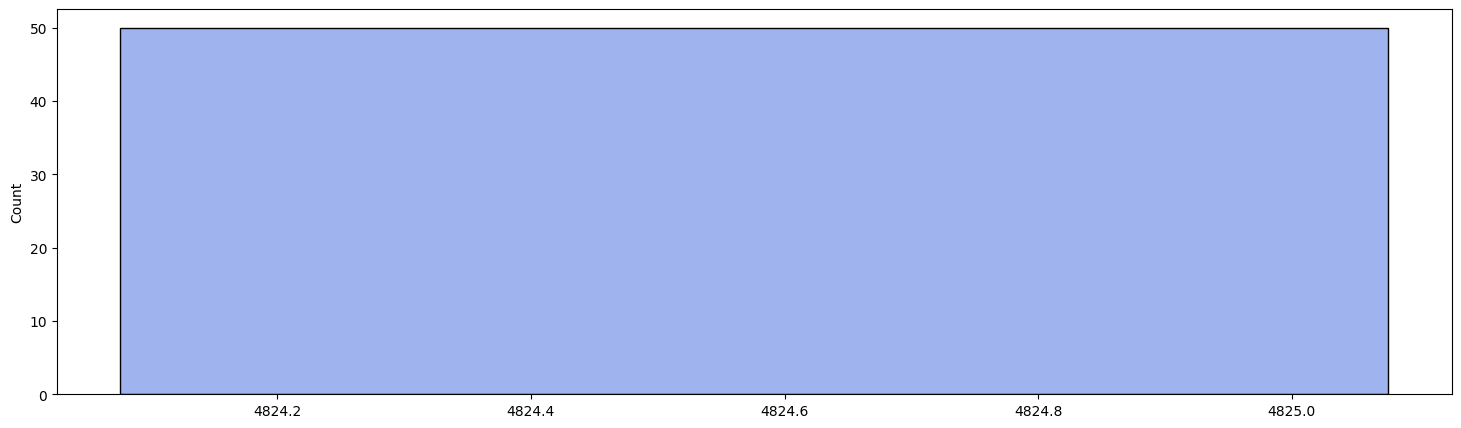

In [101]:
X_new = np.array([[1000.,1500.,5.]])
n_bootstraps = 1000
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

Lower 95 percentile = 5146.022253840908
Upper 95 percentile = 5146.022253840908
Mean Heat Output = 5146.022253840907
Standard Deviation Heat Output = 9.094947017729282e-13


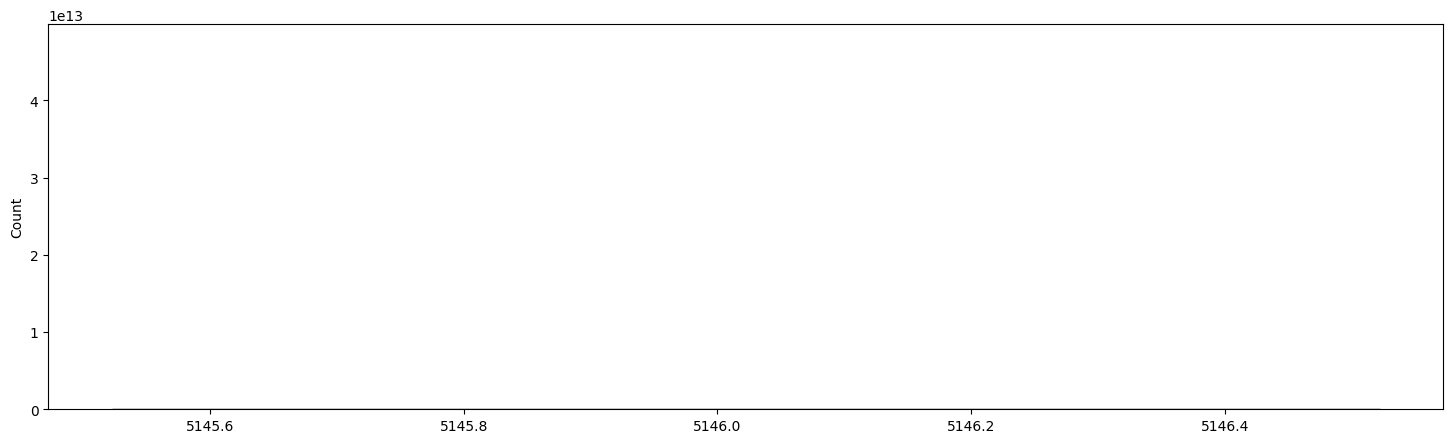

In [103]:
X_new = np.array([[1000.,1600.,5.]])
n_bootstraps = 50
percentile = 95


all_predictions = bootstrap_results(poly_interact_pipe_12, X, y, X_new, n_bootstraps, percentile, seed)

Comments about going forward

- How do we want to quantify error?
- More data?